In [1]:
#import pandas as pd  
#df = pd.read_csv("C:\\Users\\Hi\\Downloads\\online_retail_II(Year 2010-2011).csv", encoding="ISO-8859-1", parse_dates=['InvoiceDate'])
import pandas as pd

df = pd.read_csv("online_retail_II(Year 2010-2011).csv", encoding="ISO-8859-1", parse_dates=['InvoiceDate'])


In [3]:
print(df.columns.tolist())


['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


In [5]:
df = df.rename(columns={
    'Customer ID': 'CustomerID',
    'Price': 'UnitPrice'
})


In [7]:
df.columns = df.columns.str.strip().str.replace(' ', '').str.lower()
# Now: ['invoice','stockcode','description','quantity','invoicedate','price','customerid','country']


In [9]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
# => ['invoice', 'stockcode', 'description', 'quantity', 'invoice_date', 'price', 'customer_id', 'country']


In [11]:
df = pd.read_csv("C:\\Users\\Hi\\Downloads\\online_retail_II(Year 2010-2011).csv"
    ,
    encoding="unicode_escape",
    names=['invoice','stockcode','description','quantity','invoicedate','unitprice','customerid','country'],
    header=0,  # treat the first row as header
    parse_dates=['invoicedate']
)


In [13]:
df = df[df['customerid'].notna()]
df = df[df['quantity'] > 0]
df = df[df['unitprice'] > 0]
df = df[~df['invoice'].str.startswith('C', na=False)]
df['totalprice'] = df['quantity'] * df['unitprice']


In [15]:
print(df.columns.tolist())


['invoice', 'stockcode', 'description', 'quantity', 'invoicedate', 'unitprice', 'customerid', 'country', 'totalprice']


In [17]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(
    df,
    customer_id_col='customerid',
    datetime_col='invoicedate',
    monetary_value_col='totalprice',
    observation_period_end=df['invoicedate'].max()
)

# Optionally, filter to repeat customers
summary = summary[summary['frequency'] > 0]


In [61]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Predict next 6 months (≈180 days)
summary['predicted_purchases_6mo'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180,
    summary['frequency'],
    summary['recency'],
    summary['T']
)


In [19]:
from lifetimes import GammaGammaFitter

# Ensure frequency > 0
monetary_summary = summary[summary['frequency'] > 0]

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(monetary_summary['frequency'], monetary_summary['monetary_value'])

# Expected transaction value
summary.loc[monetary_summary.index, 'expected_avg_purchase'] = ggf.conditional_expected_average_profit(
    monetary_summary['frequency'],
    monetary_summary['monetary_value']
)


In [25]:
# 🧹 Filter for valid data before fitting
summary = summary[(summary['monetary_value'] > 0) & (summary['frequency'] > 0)]

# ✅ Fit the BG/NBD model
from lifetimes import BetaGeoFitter, GammaGammaFitter

bgf = BetaGeoFitter()
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# ✅ Fit the Gamma-Gamma model
ggf = GammaGammaFitter()
ggf.fit(summary['frequency'], summary['monetary_value'])

# ✅ Predict 6-month Customer Lifetime Value
summary['clv_6mo'] = ggf.customer_lifetime_value(
    transaction_prediction_model=bgf,
    frequency=summary['frequency'],
    recency=summary['recency'],
    T=summary['T'],
    monetary_value=summary['monetary_value'],
    time=6,          # Predicting 6 months
    freq='D',        # Daily frequency
    discount_rate=0.01
)


In [27]:
# Top 10 high-value customers
top_customers = summary.sort_values(by='clv_6mo', ascending=False).head(10)
print(top_customers[['clv_6mo']])


                  clv_6mo
customerid               
16446.0     119769.660353
14646.0     107010.520300
18102.0      87930.695994
17450.0      72366.737470
14096.0      56574.085061
14911.0      52084.220654
12415.0      48211.784144
14156.0      43259.757752
17511.0      33196.082529
16029.0      28399.355806


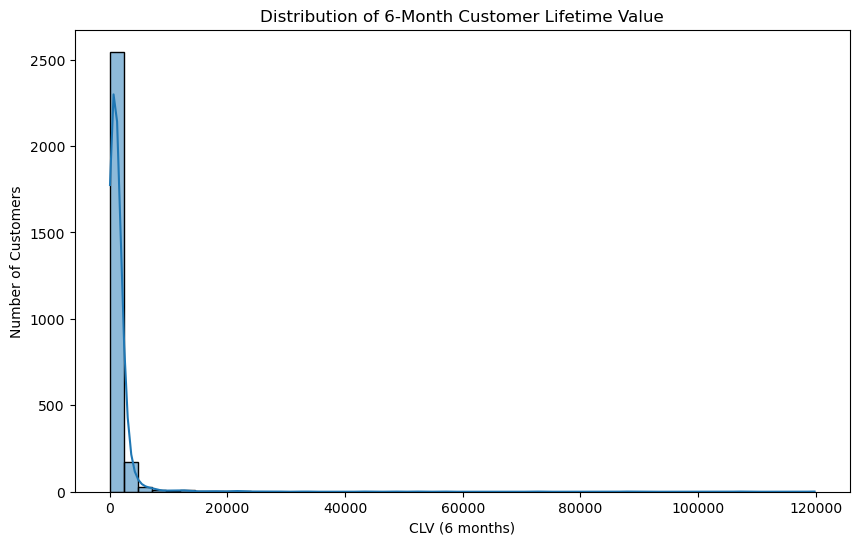

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(summary['clv_6mo'], bins=50, kde=True)
plt.title('Distribution of 6-Month Customer Lifetime Value')
plt.xlabel('CLV (6 months)')
plt.ylabel('Number of Customers')
plt.show()
